## Import libs

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import hpcom
from tqdm import tqdm

import itertools

from scipy import stats
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import plotly.graph_objects as go

matplotlib.rcParams.update({'font.size': 20})

## Additional function to process data

In [2]:
def get_label_dict_for_constellation(constellation):
    dict = {}
    k = 0
    for point in constellation:
        dict[str(point)] = k
        k += 1

    dict_inv = {v: k for k, v in dict.items()}

    return dict, dict_inv


def get_labels_for_points(points, constellation):
    labels = np.zeros(len(points))
    dict, _ = get_label_dict_for_constellation(constellation)
    k = 0
    for p in points:
        labels[k] = dict[str(p)]
        k += 1

    return labels

def get_m_neighbours(points, m):
    n = len(points)
    points = np.concatenate((points[-m:], points, points[:m]))
    result = np.array([points[k - m:k + m + 1] for k in range(m, n + m)], dtype=complex)
    return result

def form_columns_names_base(m_neighbours, general_type='x', value_type='real'):
    columns = []

    for m in range(m_neighbours, 0, -1):
        columns = columns + [f'minus_m_{m}_' + general_type + '_' + value_type]
    columns = columns + ['point_' + general_type + '_' + value_type]
    for m in range(1, m_neighbours + 1):
        columns = columns + [f'plus_m_{m}_' + general_type + '_' + value_type]

    return columns


def form_columns_names(m_neighbours, general_type='x'):
    columns = []

    columns = columns + form_columns_names_base(m_neighbours, general_type, value_type='abs')
    columns = columns + form_columns_names_base(m_neighbours, general_type, value_type='angle')
    columns = columns + form_columns_names_base(m_neighbours, general_type, value_type='real')
    columns = columns + form_columns_names_base(m_neighbours, general_type, value_type='imag')

    return columns

def get_data_with_m_neighbor_both(df, z_km, p_ave_dbm, n_channels, run_list, m_neighbours,
                                  scale_type='constellation'):
    # Create dataframe (table) with following columns:
    # neighbor symbols from -M to M, current symbol
    # optional: z_km, p_ave_dbm, n_channels
    # predict absolute value and angle for correction shift (in 2 dimensional plane -> real and imag part of symbol)

    # seed = datetime.now()
    # np.random.seed(seed)

    p_ave = (10 ** (p_ave_dbm / 10)) / 1000
    mod_type = hpcom.modulation.get_modulation_type_from_order(16)
    scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave / 2)
    constellation = hpcom.modulation.get_constellation(mod_type)

    scale = 1
    if scale_type == 'constellation':
        print('Scale data to correspond to initial constellation')
        scale = scale_constellation
    else:
        print('No such type of scale_type. Set scale to 1')

    columns = ['point_orig_abs', 'point_orig_angle',
               'point_orig_real', 'point_orig_imag',
               'point_label',
               'point_x_shifted_real', 'point_x_shifted_imag',
               'diff_real', 'diff_imag']

    columns = columns + form_columns_names(m_neighbours, general_type='x')
    columns = columns + form_columns_names(m_neighbours, general_type='y')

    columns = columns + form_columns_names(m_neighbours, general_type='orig_x')

    # print(columns)

    df_result = pd.DataFrame(columns=columns)
    # print(df_result)

    for run in tqdm(run_list):
        # print('run number', run)
        df_current = df[(df['z_km'] == z_km) & (df['p_ave_dbm'] == p_ave_dbm) & (df['n_channels'] == n_channels) & (
                df['run'] == run)]

        points_x_orig = df_current['points_x_orig'].iloc[0][0] * scale
        points_x_scaled = hpcom.modulation.get_nearest_constellation_points_new(
            points_x_orig * scale_constellation / scale,
            constellation)
        points_x_scaled_with_neighbours = get_m_neighbours(points_x_scaled, m_neighbours)
        # points_x_labels_str = list(map(str, points_x_scaled))
        points_x_labels = get_labels_for_points(points_x_scaled, constellation)

        points_x_shifted = df_current['points_x_shifted'].iloc[0] * scale
        points_x_with_neighbours = get_m_neighbours(points_x_shifted, m_neighbours)
        points_diff = points_x_orig - points_x_shifted

        # print(np.shape(points_x_with_neighbours))

        # points_y_orig = df_current['points_y_orig'].iloc[0][0]
        points_y_shifted = df_current['points_y_shifted'].iloc[0] * scale
        points_y_with_neighbours = get_m_neighbours(points_y_shifted, m_neighbours)
        # points_y_scaled = sg.get_nearest_constellation_points_new(points_y_orig * scale_constellation, constellation)

        n_points = len(points_x_orig)


        data = np.column_stack((np.absolute(points_x_orig), np.angle(points_x_orig),
                                np.real(points_x_orig), np.imag(points_x_orig),
                                points_x_labels,
                                np.real(points_x_shifted), np.imag(points_x_shifted),
                                np.real(points_diff), np.imag(points_diff),
                                np.absolute(points_x_with_neighbours), np.angle(points_x_with_neighbours),
                                np.real(points_x_with_neighbours), np.imag(points_x_with_neighbours),
                                np.absolute(points_y_with_neighbours), np.angle(points_y_with_neighbours),
                                np.real(points_y_with_neighbours), np.imag(points_y_with_neighbours),
                                np.absolute(points_x_scaled_with_neighbours), np.angle(points_x_scaled_with_neighbours),
                                np.real(points_x_scaled_with_neighbours), np.imag(points_x_scaled_with_neighbours),))

        # TODO: check if the order is correct
        # seems that has to be:
        # np.absolute(points_x_with_neighbours), np.angle(points_x_with_neighbours),
        # np.real(points_x_with_neighbours), np.imag(points_x_with_neighbours),
        # np.absolute(points_y_with_neighbours), np.angle(points_y_with_neighbours),
        # np.real(points_y_with_neighbours), np.imag(points_y_with_neighbours)))
        # it will not lead to the error but can

        # print(np.shape(data))

        df_result = pd.concat([df_result, pd.DataFrame(data, columns=columns)], ignore_index=True)

        # k = 1
        # one_row = [np.absolute(points_x_orig[k]), np.angle(points_x_orig[k]),
        #                         np.real(points_diff[k]), np.imag(points_diff[k]),
        #                         np.real(points_diff_sq[k]), np.imag(points_diff_sq[k]),
        #                         np.real(points_diff_circle[k]), np.imag(points_diff_circle[k])]
        # print(one_row, np.absolute(points_with_neighbours[k]), np.angle(points_with_neighbours[k]))
        # print(np.array(df_result.iloc[k]))
        # if np.isclose(np.array(df_result.iloc[0]), one_row):
        #     print('Error')

    return df_result

def get_points_run(df, z_km, p_ave_dbm, n_channels, run_list, m_neighbours,
                                  scale_type='constellation'):
    # Create dataframe (table) with following columns:
    # neighbor symbols from -M to M, current symbol
    # optional: z_km, p_ave_dbm, n_channels
    # predict absolute value and angle for correction shift (in 2 dimensional plane -> real and imag part of symbol)

    # seed = datetime.now()
    # np.random.seed(seed)

    p_ave = (10 ** (p_ave_dbm / 10)) / 1000
    mod_type = hpcom.modulation.get_modulation_type_from_order(16)
    scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave / 2)
    constellation = hpcom.modulation.get_constellation(mod_type)

    scale = 1
    if scale_type == 'constellation':
        print('Scale data to correspond to initial constellation')
        scale = scale_constellation
    else:
        print('No such type of scale_type. Set scale to 1')

    columns = ['point_orig_real', 'point_orig_imag',
               'point_label',
               'point_x_shifted_real', 'point_x_shifted_imag']

    df_result = pd.DataFrame(columns=columns)
    # print(df_result)

    for run in tqdm(run_list):
        # print('run number', run)
        df_current = df[(df['z_km'] == z_km) & (df['p_ave_dbm'] == p_ave_dbm) & (df['n_channels'] == n_channels) & (
                df['run'] == run)]

        points_x_orig = df_current['points_x_orig'].iloc[0][0] * scale
        points_x_scaled = hpcom.modulation.get_nearest_constellation_points_new(
            points_x_orig * scale_constellation / scale,
            constellation)

        points_x_labels = get_labels_for_points(points_x_scaled, constellation)
        points_x_shifted = df_current['points_x_shifted'].iloc[0] * scale

        # points_y_orig = df_current['points_y_orig'].iloc[0][0]
        points_y_shifted = df_current['points_y_shifted'].iloc[0] * scale

        n_points = len(points_x_orig)
        run_column = run * np.ones(len(points_x_labels))

        data = np.column_stack((np.real(points_x_scaled), np.imag(points_x_scaled),
                                points_x_labels,
                                np.real(points_x_shifted), np.imag(points_x_shifted),
                                run_column))

        # TODO: check if the order is correct
        # seems that has to be:
        # np.absolute(points_x_with_neighbours), np.angle(points_x_with_neighbours),
        # np.real(points_x_with_neighbours), np.imag(points_x_with_neighbours),
        # np.absolute(points_y_with_neighbours), np.angle(points_y_with_neighbours),
        # np.real(points_y_with_neighbours), np.imag(points_y_with_neighbours)))
        # it will not lead to the error but can

        # print(np.shape(data))

        df_result = pd.concat([df_result, pd.DataFrame(data, columns=columns)], ignore_index=True)

        # k = 1
        # one_row = [np.absolute(points_x_orig[k]), np.angle(points_x_orig[k]),
        #                         np.real(points_diff[k]), np.imag(points_diff[k]),
        #                         np.real(points_diff_sq[k]), np.imag(points_diff_sq[k]),
        #                         np.real(points_diff_circle[k]), np.imag(points_diff_circle[k])]
        # print(one_row, np.absolute(points_with_neighbours[k]), np.angle(points_with_neighbours[k]))
        # print(np.array(df_result.iloc[k]))
        # if np.isclose(np.array(df_result.iloc[0]), one_row):
        #     print('Error')

    return df_result

## Read data

In [3]:
datafile_path = '../benchmark/data/data_collected_errorstat_wo_noise_1.pkl'
df = pd.read_pickle(datafile_path)


In [4]:
df[df.run < 64].to_pickle(datafile_path[:-4] + '_runmax_64.pkl')

You can re-save file in parquet format

In [5]:
datafile_path = '../benchmark/data/data_collected_errorstat_wo_noise_1.pkl'
datafile_path_parquet = datafile_path[:-3] + 'parquet'

print(datafile_path)
print(datafile_path_parquet)

df = pd.read_pickle(datafile_path)
df.to_parquet(datafile_path_parquet, engine='pyarrow')

../benchmark/data/data_collected_errorstat_wo_noise_1.pkl
../benchmark/data/data_collected_errorstat_wo_noise_1.parquet


ArrowNotImplementedError: ('Unsupported numpy type 15', 'Conversion failed for column points_x_orig with type object')

### Process raw data
If you have a look to df you will what values of *variable* you have.
List of variables:
* `p_ave_dbm`
* `z_km`

`n_channels` in our case is always 1

If you want not more neighbor symbols (`m_neighbours = 1` for triplets) you can increase `m_neighbours`


In [4]:
df.z_km.unique

<bound method Series.unique of 0       1200
1       1200
2       1200
3       1200
4       1200
        ... 
2043    1200
2044    1200
2045    1200
2046    1200
2047    1200
Name: z_km, Length: 2048, dtype: int64>

In [5]:
df

run  n_channels  p_ave_dbm  z_km  noise_figure_db  gamma  z_span  \
0       0           1          0  1200             -200    1.2      80   
1       1           1          0  1200             -200    1.2      80   
2       2           1          0  1200             -200    1.2      80   
3       3           1          0  1200             -200    1.2      80   
4       4           1          0  1200             -200    1.2      80   
...   ...         ...        ...   ...              ...    ...     ...   
2043  251           1          7  1200             -200    1.2      80   
2044  252           1          7  1200             -200    1.2      80   
2045  253           1          7  1200             -200    1.2      80   
2046  254           1          7  1200             -200    1.2      80   
2047  255           1          7  1200             -200    1.2      80   

      dispersion_parameter  dz  \
0                     16.8   1   
1                     16.8   1   
2                     16.8   1   
3                     16.8   1   
4                     16.8   1   
...                    ...  ..   
2043                  16.8   1   
2044                  16.8   1   
2045                  16.8   1   
2046                  16.8   1   
2047                  16.8   1   

                                          points_x_orig  \
0     [[(0.021213203435596423-0.0070710678118654745j...   
1     [[(0.021213203435596423-0.0070710678118654745j...   
2     [[(-0.0070710678118654745+0.021213203435596423...   
3     [[(0.0070710678118654745-0.021213203435596423j...   
4     [[(-0.0070710678118654745+0.007071067811865474...   
...                                                 ...   
2043  [[(0.015830148982673414-0.04749044694802024j),...   
2044  [[(-0.015830148982673414-0.015830148982673414j...   
2045  [[(0.04749044694802024+0.015830148982673414j),...   
2046  [[(-0.04749044694802024+0.04749044694802024j),...   
2047  [[(-0.04749044694802024-0.015830148982673414j)...   

                                               points_x  \
0     [(3.245856305954687e-07+7.11303329331912e-08j)...   
1     [(3.370058971223033e-07+5.1441558853721036e-08...   
2     [(-2.521247537894262e-07+2.2289447498782458e-0...   
3     [(2.6476958506057004e-07-2.3732242900254775e-0...   
4     [(-1.5415924287519632e-07+3.598451669982928e-0...   
...                                                 ...   
2043  [(3.083639203953217e-07+7.406668254632058e-07j...   
2044  [(7.511782136412653e-08+1.3367556272567696e-07...   
2045  [(-6.424156303758257e-07+4.498778799004138e-07...   
2046  [(2.982024472082702e-07-9.391975695022976e-07j...   
2047  [(4.546270642205358e-07-2.025341432170928e-07j...   

                                       points_x_shifted  \
0     [(0.02148548172393643-0.006386352026608681j), ...   
1     [(0.021579107598423238-0.00794069121936104j), ...   
2     [(-0.007635802917817734+0.02137536029458803j),...   
3     [(0.007948712274997397-0.02262819027374119j), ...   
4     [(-0.007935744261618295+0.007144477420785424j)...   
...                                                 ...   
2043  [(0.011957314266023766-0.055441365337872375j),...   
2044  [(0.0009338585076751329-0.010810965119118984j)...   
2045  [(0.055523346034360765-0.000718214955808167j),...   
2046  [(-0.054906244180674815+0.04291976780582791j),...   
2047  [(-0.03462974484429235-0.006388464606408685j),...   

                                          points_y_orig  \
0     [[(0.0070710678118654745+0.0070710678118654745...   
1     [[(0.021213203435596423-0.0070710678118654745j...   
2     [[(0.0070710678118654745-0.0070710678118654745...   
3     [[(0.0070710678118654745+0.0070710678118654745...   
4     [[(-0.021213203435596423+0.021213203435596423j...   
...                                                 ...   
2043  [[(0.015830148982673414-0.04749044694802024j),...   
2044  [[(-0.04749044694802024+0.04749044694802024j),...   
2045  [[(-0.04749044694802024+0.015830148982673414

In [16]:
z_km = 1200
p_ave_dbm = 0
n_channels = 1
m_neighbours = 1
run_list = np.arange(256)
df_work = get_data_with_m_neighbor_both(df, z_km, p_ave_dbm, n_channels, run_list, m_neighbours,
                                  scale_type='constellation')

Scale data to correspond to initial constellation


100%|██████████| 256/256 [05:37<00:00,  1.32s/it]


Show data

In [ ]:
df_work

In [17]:
# point_x_shifted is the final point in the constellation which we receive
columns_selected = ['minus_m_1_orig_x_real', 'point_orig_x_real', 'plus_m_1_orig_x_real',
                  'minus_m_1_orig_x_imag', 'point_orig_x_imag', 'plus_m_1_orig_x_imag',
                  'point_label',
                  'point_x_shifted_real', 'point_x_shifted_imag']

df_selected = df_work[columns_selected]

In [21]:
# 16-QAM points
# +- [1,3] +- [1,3]j
triplet_left_point = -3.0 + -3.0j
triplet_central_point = -3.0 + -1.0j
triplet_right_point = -3.0 + -3.0j

# only one triplet
# df_one = df_selected[
#     (
#         (df_selected.minus_m_1_orig_x_real == np.real(triplet_left_point)) &
#         (df_selected.minus_m_1_orig_x_imag == np.imag(triplet_left_point)) &
#         (df_selected.point_orig_x_real == np.real(triplet_central_point)) &
#         (df_selected.point_orig_x_imag == np.imag(triplet_central_point)) &
#         (df_selected.plus_m_1_orig_x_real == np.real(triplet_right_point)) &
#         (df_selected.plus_m_1_orig_x_imag == np.imag(triplet_right_point))
#     )
# ]

# all triplets for particular central point
df_one = df_selected[
    (
        (df_selected.point_orig_x_real == np.real(triplet_central_point)) &
        (df_selected.point_orig_x_imag == np.imag(triplet_central_point))
    )
]


points_shifted_one = df_one.point_x_shifted_real.values + 1j * df_one.point_x_shifted_imag.values
print(np.shape(points_shifted_one))  # print how much points you have in your distribution

(1049058,)


## Plot distribution

In [22]:
plot_max_value = 1  # range for maximum deviation for x and y axe
x_min, x_max = -plot_max_value, plot_max_value
y_min, y_max = x_min, x_max  # the same as for x but can be custom
n_bins = 50  # number of bins for histogram
x_bins = np.linspace(x_min, x_max, n_bins)
y_bins = np.linspace(y_min, y_max, n_bins)

# shift all points to make center point equal to triplet_central_point
x = points_shifted_one.real - triplet_central_point.real
y = points_shifted_one.imag - triplet_central_point.imag

# create histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=(n_bins,n_bins), range=[[x_min, x_max], [y_min, y_max]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])

xpos = xpos.flatten()*1./2
ypos = ypos.flatten()*1./2
zpos = np.zeros_like (xpos)

dx = xedges[1] - xedges[0]
dy = yedges[1] - yedges[0]
dz = hist.flatten()

cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz]

C:\Users\190243539\AppData\Local\Temp\ipykernel_153840\1907656780.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!


### Interactive but heavy plot

In [ ]:
fig = go.Figure(data=[go.Surface(z=hist, x=xedges, y=yedges)])
fig.update_layout(title='Histogram', autosize=False,
                  width=1000, height=1000)
fig.show()

### Not interactive but not so resource consumable

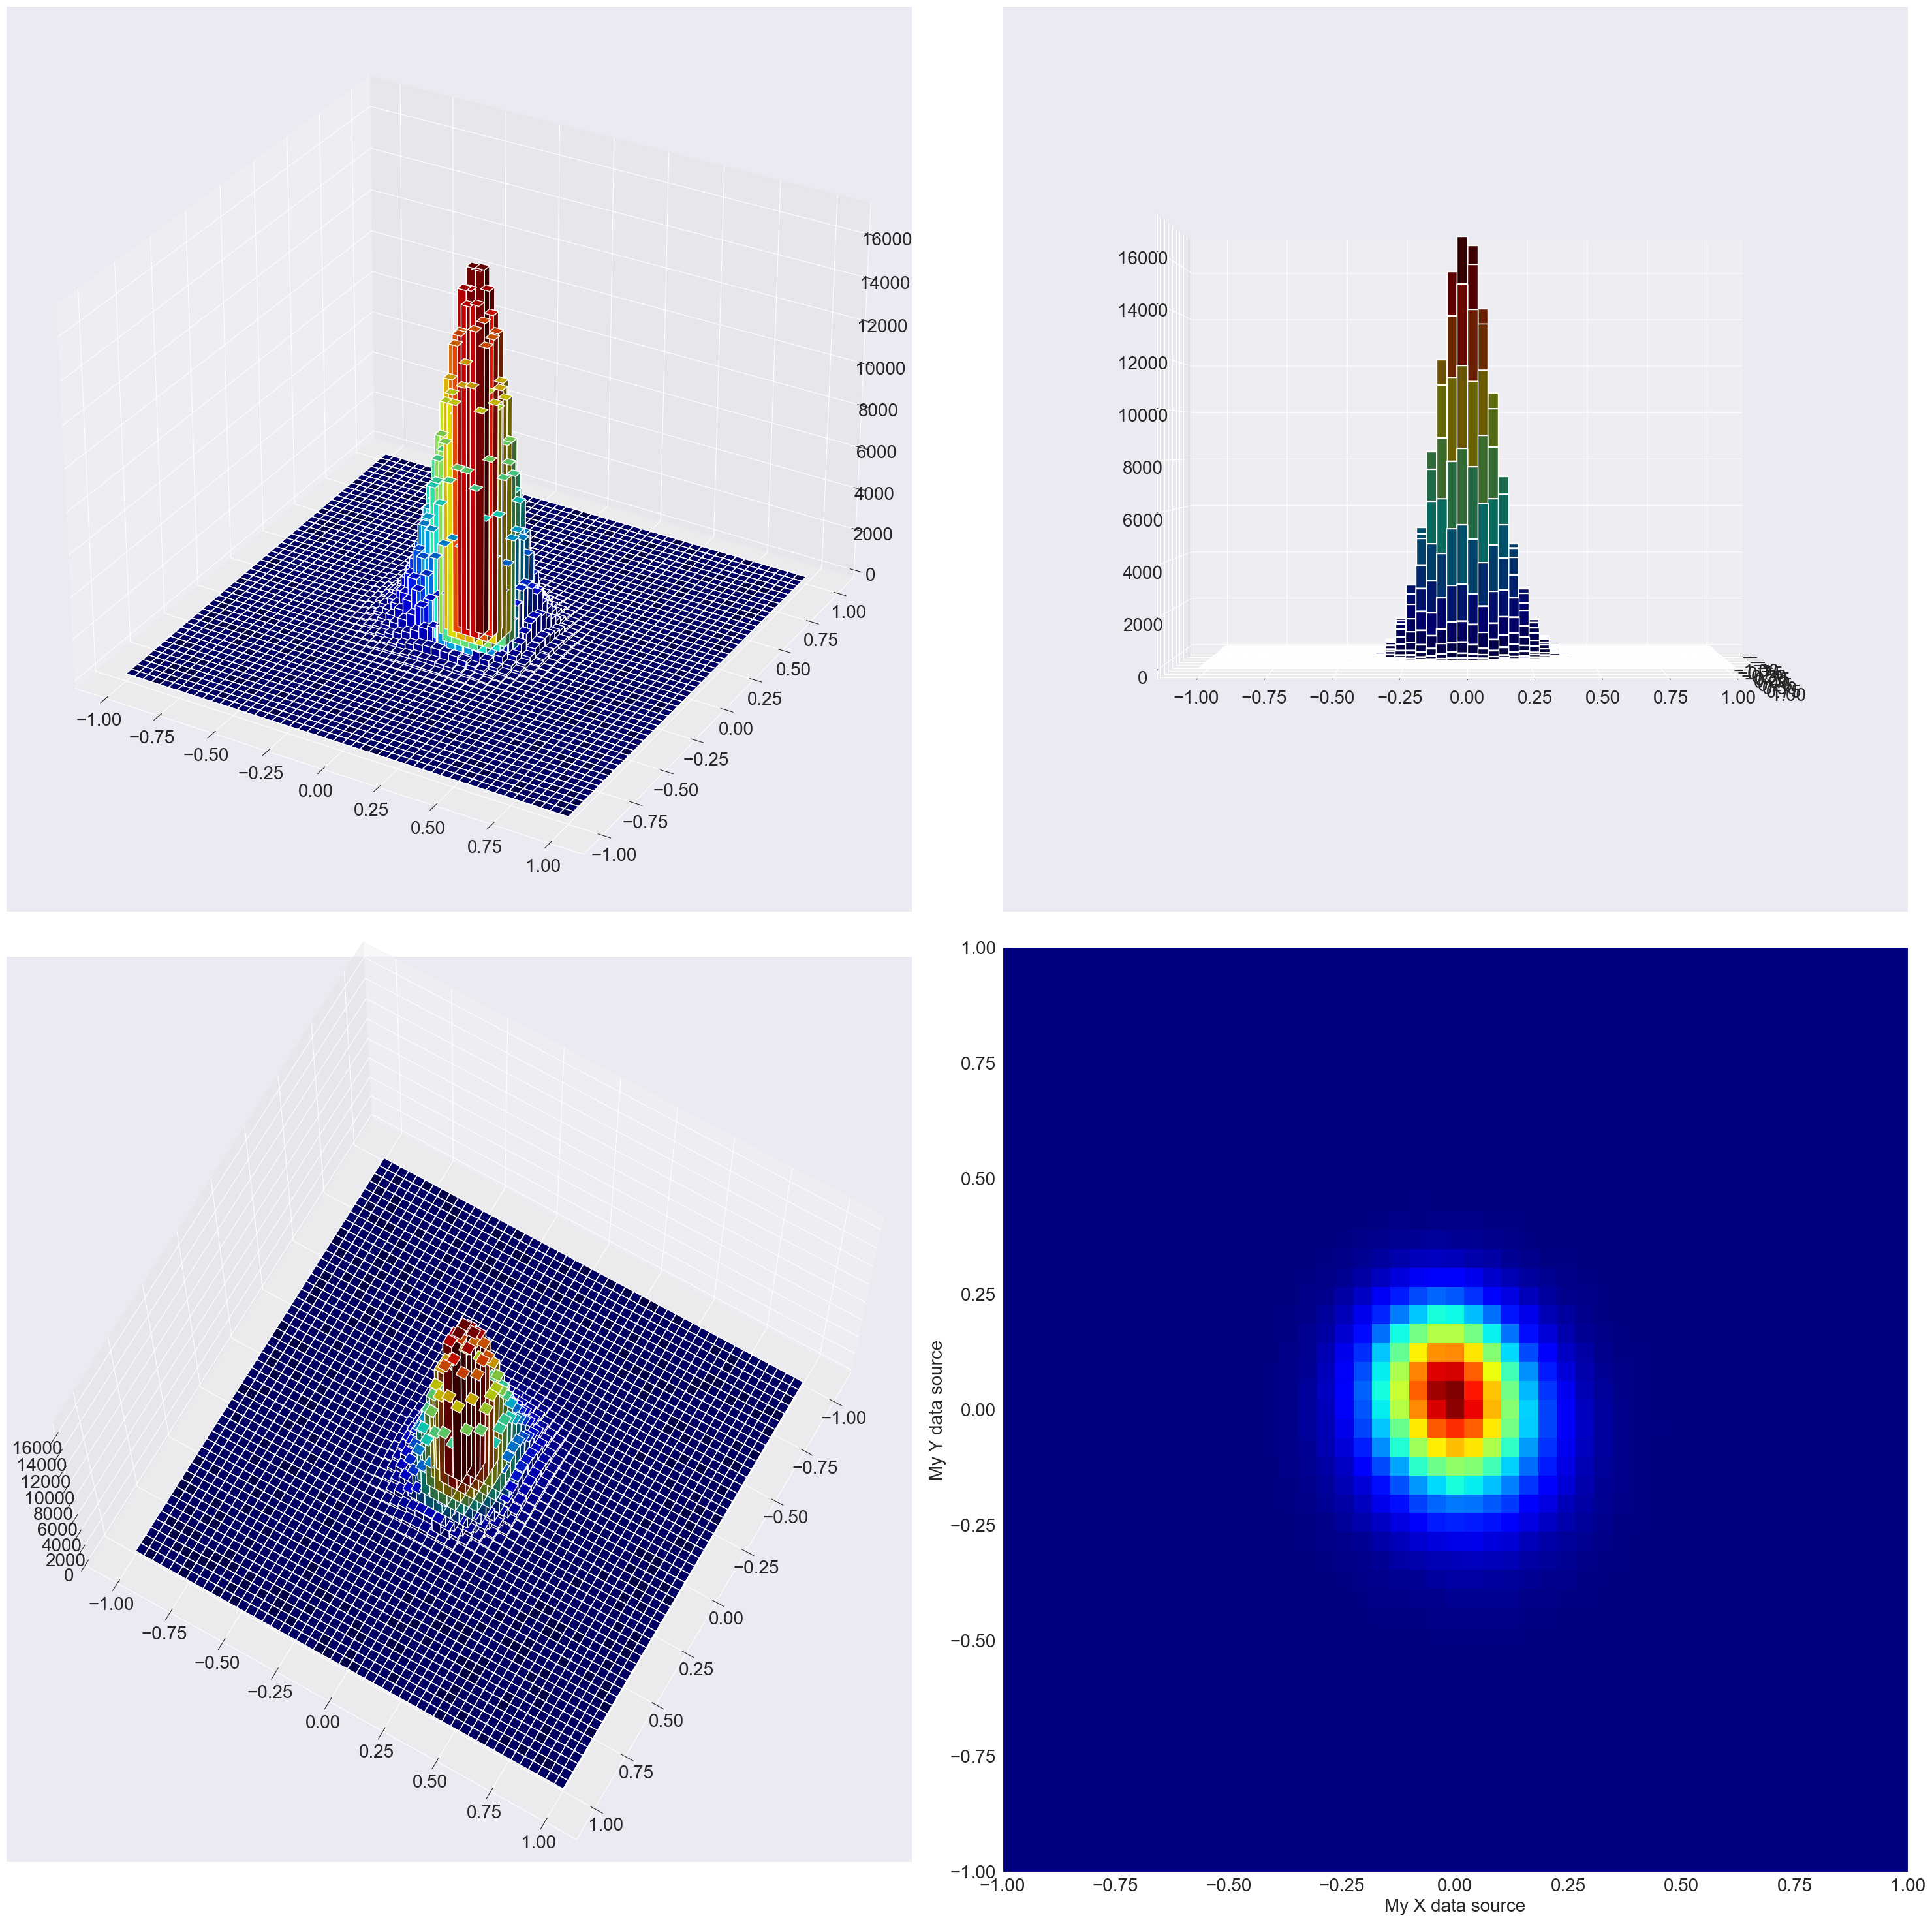

In [23]:
color_map = plt.cm.jet

fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(221, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')

ax2 = fig.add_subplot(222, projection='3d')
ax2.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax2.view_init(0, 0)  # you can select the view for 3d graph (see doc)

ax3 = fig.add_subplot(223, projection='3d')
ax3.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax3.view_init(70, 30)

ax4 = fig.add_subplot(224)
# ax4.hexbin(xedges, yedges, hist, color=rgba)

ax4.hist2d(x, y, bins=[x_bins, y_bins], cmap=color_map)

# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
# plt.title("X vs. Y Amplitudes for ____ Data")
plt.xlabel("My X data source")
plt.ylabel("My Y data source")

# Set tight layout
plt.tight_layout()

# plt.savefig(data_dir + job_name + '.pdf', format="pdf")
plt.show()

# K-clusters for phase equalisation

In [39]:
from sklearn.cluster import KMeans
import numpy as np

In [6]:
df

run  n_channels  p_ave_dbm  z_km  noise_figure_db  gamma  z_span  \
0       0           1          0  1200             -200    1.2      80   
1       1           1          0  1200             -200    1.2      80   
2       2           1          0  1200             -200    1.2      80   
3       3           1          0  1200             -200    1.2      80   
4       4           1          0  1200             -200    1.2      80   
...   ...         ...        ...   ...              ...    ...     ...   
2043  251           1          7  1200             -200    1.2      80   
2044  252           1          7  1200             -200    1.2      80   
2045  253           1          7  1200             -200    1.2      80   
2046  254           1          7  1200             -200    1.2      80   
2047  255           1          7  1200             -200    1.2      80   

      dispersion_parameter  dz  \
0                     16.8   1   
1                     16.8   1   
2                     16.8   1   
3                     16.8   1   
4                     16.8   1   
...                    ...  ..   
2043                  16.8   1   
2044                  16.8   1   
2045                  16.8   1   
2046                  16.8   1   
2047                  16.8   1   

                                          points_x_orig  \
0     [[(0.021213203435596423-0.0070710678118654745j...   
1     [[(0.021213203435596423-0.0070710678118654745j...   
2     [[(-0.0070710678118654745+0.021213203435596423...   
3     [[(0.0070710678118654745-0.021213203435596423j...   
4     [[(-0.0070710678118654745+0.007071067811865474...   
...                                                 ...   
2043  [[(0.015830148982673414-0.04749044694802024j),...   
2044  [[(-0.015830148982673414-0.015830148982673414j...   
2045  [[(0.04749044694802024+0.015830148982673414j),...   
2046  [[(-0.04749044694802024+0.04749044694802024j),...   
2047  [[(-0.04749044694802024-0.015830148982673414j)...   

                                               points_x  \
0     [(3.245856305954687e-07+7.11303329331912e-08j)...   
1     [(3.370058971223033e-07+5.1441558853721036e-08...   
2     [(-2.521247537894262e-07+2.2289447498782458e-0...   
3     [(2.6476958506057004e-07-2.3732242900254775e-0...   
4     [(-1.5415924287519632e-07+3.598451669982928e-0...   
...                                                 ...   
2043  [(3.083639203953217e-07+7.406668254632058e-07j...   
2044  [(7.511782136412653e-08+1.3367556272567696e-07...   
2045  [(-6.424156303758257e-07+4.498778799004138e-07...   
2046  [(2.982024472082702e-07-9.391975695022976e-07j...   
2047  [(4.546270642205358e-07-2.025341432170928e-07j...   

                                       points_x_shifted  \
0     [(0.02148548172393643-0.006386352026608681j), ...   
1     [(0.021579107598423238-0.00794069121936104j), ...   
2     [(-0.007635802917817734+0.02137536029458803j),...   
3     [(0.007948712274997397-0.02262819027374119j), ...   
4     [(-0.007935744261618295+0.007144477420785424j)...   
...                                                 ...   
2043  [(0.011957314266023766-0.055441365337872375j),...   
2044  [(0.0009338585076751329-0.010810965119118984j)...   
2045  [(0.055523346034360765-0.000718214955808167j),...   
2046  [(-0.054906244180674815+0.04291976780582791j),...   
2047  [(-0.03462974484429235-0.006388464606408685j),...   

                                          points_y_orig  \
0     [[(0.0070710678118654745+0.0070710678118654745...   
1     [[(0.021213203435596423-0.0070710678118654745j...   
2     [[(0.0070710678118654745-0.0070710678118654745...   
3     [[(0.0070710678118654745+0.0070710678118654745...   
4     [[(-0.021213203435596423+0.021213203435596423j...   
...                                                 ...   
2043  [[(0.015830148982673414-0.04749044694802024j),...   
2044  [[(-0.04749044694802024+0.04749044694802024j),...   
2045  [[(-0.04749044694802024+0.015830148982673414

In [53]:
z_km = 1200
p_ave_dbm = 5  # [0 .. 7]
n_channels = 1

df_work = df[(df.p_ave_dbm == p_ave_dbm) & (df.run == 32)]

In [55]:
df_work

run  n_channels  p_ave_dbm  z_km  noise_figure_db  gamma  z_span  \
1312   32           1          5  1200             -200    1.2      80   

      dispersion_parameter  dz  \
1312                  16.8   1   

                                          points_x_orig  \
1312  [[(-0.012574334296829354+0.037723002890488064j...   

                                               points_x  \
1312  [(-4.3589160467149343e-07-1.1591685275138006e-...   

                                       points_x_shifted  \
1312  [(-0.007207327027111399+0.030118169508308115j)...   

                                          points_y_orig  \
1312  [[(0.012574334296829354-0.012574334296829354j)...   

                                               points_y  \
1312  [(2.567507501201881e-07+1.6274069792842553e-07...   

                                       points_y_shifted  \
1312  [(0.010648352797134289-0.017952851616907396j),...   

                            ber_x                         ber_y       q_x  \
1312  (0.01003265380859375, 2630)  (0.010227203369140625, 2681)  2.325124   

           q_y  
1312  2.317906

In [54]:
points_x_orig = df_work.points_x_orig.values[0][0]
points_x = df_work.points_x.values[0]
points_x_shifted = df_work.points_x_shifted.values[0]

In [43]:
points_x_orig

array([ 0.0212132 -0.00707107j, -0.0212132 -0.0212132j ,
       -0.00707107+0.0212132j , ...,  0.0212132 +0.0212132j ,
       -0.00707107-0.0212132j , -0.0212132 +0.0212132j ])

In [44]:
points_x

array([ 3.24585631e-07+7.11303329e-08j, -1.23972628e-07-4.52500764e-07j,
       -2.59961517e-07+2.37375385e-07j, ...,
        1.13853080e-07+4.16336799e-07j,  8.74107759e-08-3.13278563e-07j,
       -4.16337720e-07+9.85873788e-08j])

In [13]:
color = ['xkcd:violet', 'xkcd:royal blue', 'xkcd:green blue', 'xkcd:terra cotta', 'xkcd:brick red', 'xkcd:light purple']
color_add = ['xkcd:light purple', 'xkcd:azure', 'xkcd:aqua green', 'xkcd:tangerine', 'xkcd:light red', 'xkcd:violet']

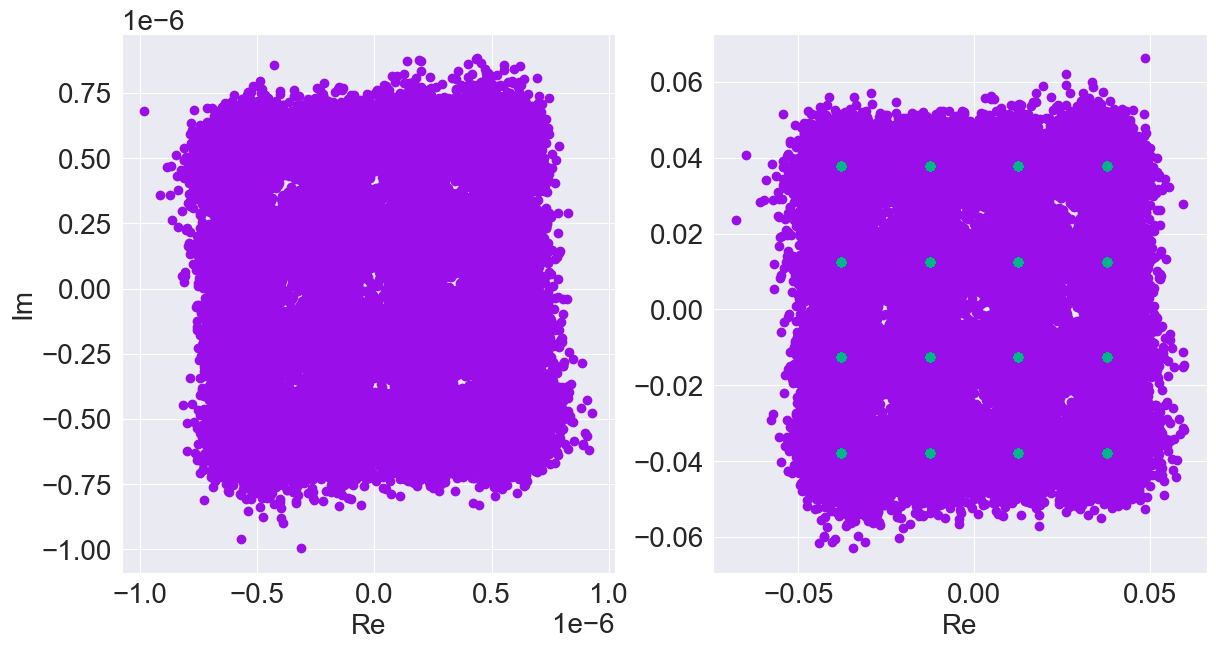

In [51]:
# draw constellation


fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Create a scatter plot
ax[0].scatter(points_x.real,
              points_x.imag,
              color=color[0])

ax[1].scatter(points_x_shifted.real,
              points_x_shifted.imag,
              color=color[0])
ax[1].scatter(points_x_orig.real,
              points_x_orig.imag,
              color=color[2])

# Label the axes
ax[0].set_xlabel('Re')
ax[0].set_ylabel('Im')

ax[1].set_xlabel('Re')
# ax[1].set_ylabel('Im')


# Show the plot
plt.show()

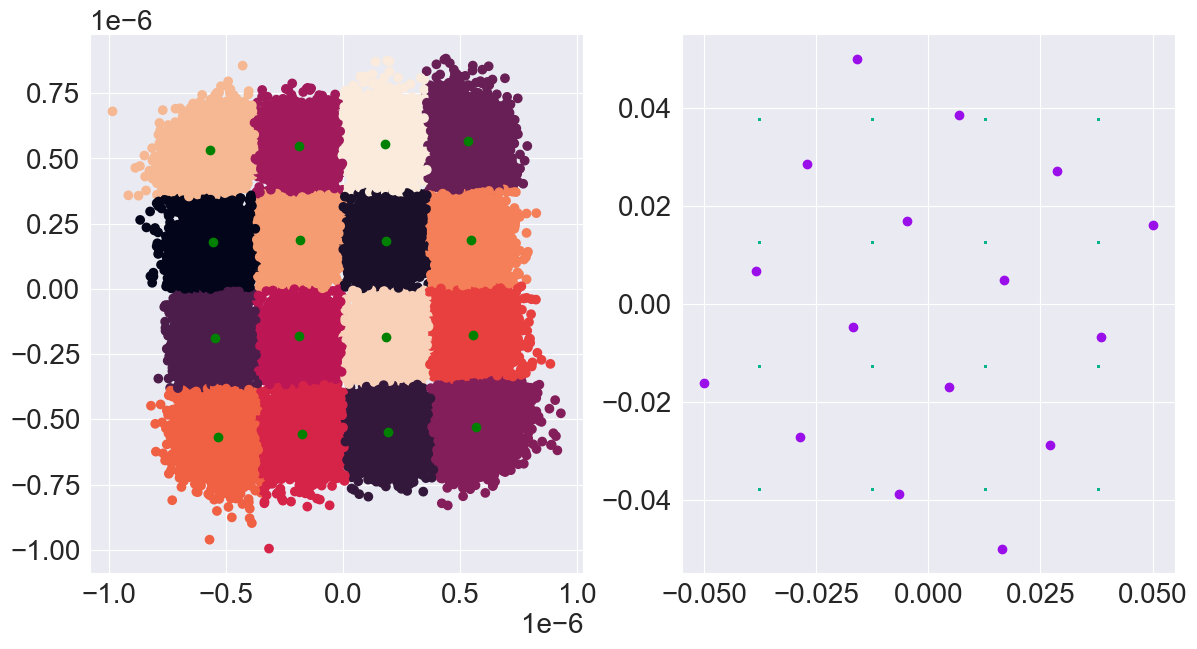

In [52]:
# create a 2D array with the real and imaginary parts
data = np.column_stack((np.real(points_x), np.imag(points_x)))

# Create a KMeans instance with the number of clusters you want (let's say 4)
kmeans = KMeans(n_clusters=16)

# Fit the model to your data
kmeans.fit(data)

# Get the cluster assignments for each data point
labels = kmeans.labels_

# Get the cluster centers
centers = kmeans.cluster_centers_
centers_number = centers[:, 0] + 1j * centers[:, 1]

# You can also predict the cluster for any point
predictions = kmeans.predict(data)

# Plotting the clusters
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

ax[0].scatter(data[:,0], data[:,1], c=labels)
ax[0].scatter(centers[:,0], centers[:,1], c='green')  # Plot the cluster centers

ax[1].scatter(np.real(centers_number * nl_shift),
              np.imag(centers_number * nl_shift),
              color=color[0])
ax[1].scatter(points_x_orig.real,
              points_x_orig.imag,
              color=color[2],
              s=1)

plt.show()

In [20]:
def nonlinear_shift(points, points_orig):
    return np.dot(np.transpose(np.conjugate(points_orig)), points_orig) / np.dot(np.transpose(np.conjugate(points_orig)), points)


In [47]:
nl_shift = nonlinear_shift(points_x, points_x_orig)
print(nl_shift)

(59046.27339022019-32614.916106723853j)


In [22]:
print(np.max(np.absolute(points_x * nl_shift - points_x_shifted)))

0.0


In [25]:

print(centers_number)

[ 2.25076605e-07+2.43135892e-07j -2.25606076e-07-2.43286863e-07j
  3.25948766e-07+5.94504936e-08j -5.94186774e-08+3.26376668e-07j
 -4.28085656e-07+1.21063855e-07j  5.93472236e-08-3.26140621e-07j
 -1.42057985e-07+4.22620285e-08j  1.42254589e-07-4.23150177e-08j
  2.43069490e-07-2.25420332e-07j  1.21303593e-07+4.27628589e-07j
 -4.22746585e-08-1.41982700e-07j -1.21683492e-07-4.27773891e-07j
  4.24946439e-08+1.42047059e-07j -2.43394682e-07+2.25149574e-07j
 -3.26122732e-07-5.93517654e-08j  4.27617450e-07-1.21837735e-07j]
